# CITS4403 Project Notebook — Feral Cats vs Prey ABM

**Date:** 2025-10-04  
**Authors:** *(fill in team members)*  
**Repo:** *https://github.com/Oliverkkkk/Feral_Cats_and_Small_Mammals.git*

This notebook documents the modelling process, experiments, and results.

## 1. Reproducibility & Environment

- Set a global random seed for Python/NumPy (and Torch if present).  
- Capture package versions to enable reproduction.  
- If running in a fresh environment, use `requirements.txt`.

In [3]:
# Optional: one-time install if running in a fresh environment
# !pip install -r ../requirements.txt

import os, sys, random, importlib
import numpy as np

# Make project root importable and ensure 'src' is a package
PROJ_ROOT = os.path.abspath("..") if os.path.isdir("..") else os.getcwd()
if PROJ_ROOT not in sys.path:
    sys.path.insert(0, PROJ_ROOT)

SEED = 4403
random.seed(SEED)
np.random.seed(SEED)
try:
    import torch
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)
except Exception:
    pass

def _ver(modname):
    try:
        m = importlib.import_module(modname)
        return getattr(m, "__version__", "n/a")
    except Exception:
        return "not installed"

print("Python:", sys.version.split()[0])
print("numpy:", _ver("numpy"))
print("matplotlib:", _ver("matplotlib"))
print("pandas:", _ver("pandas"))
print("mesa:", _ver("mesa"))
print("torch:", _ver("torch"))

Python: 3.12.3
numpy: 2.3.3
matplotlib: 3.10.6
pandas: 2.3.2
mesa: 3.3.0
torch: not installed


## 2. Model Overview

We use a grid-based ABM with **cats** (predators) and **prey** (small mammals). The environment supports **vegetation** (0–4) and an optional **river** mask (blocked cells). Key ideas:

- Prey move locally and prefer higher vegetation; females may reproduce when vegetation is sufficient and a male is nearby, after a cooldown.  
- Cats move locally, biasing recent prey trails; they attempt predation once per sub-step and gain energy on success; energy depletes over time leading to death.  
- A **cat scent** field (Chebyshev radius ≤ 2) is refreshed each step and can trigger prey fleeing.

In [4]:
# Import the project modules from src/
from src.model import FeralCatModel, count_cats, count_prey
from src.visual2d import animate_grid
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

### Model Parameters

We centralise key parameters for clarity and reuse in experiments.

| Parameter | Type (Default) | What it controls | Typical range / notes |
|---|---|---|---|
| `width`, `height` | `int` (25, 25) | Size of the 2-D grid in cells (columns × rows). Total habitat size is `width × height`. | Larger grids dilute encounters; smaller grids increase contact rates. Keep vegetation/river maps the same shape. |
| `n_cats` | `int` (6) | Initial number of predator agents (cats). | Higher values increase early predation pressure and energy turnover. |
| `n_prey` | `int` (40) | Initial number of prey agents. | Sets starting prey density; affects time to equilibrium/extinction. |
| `predation_base` | `float` (0.20) | Baseline per-encounter predation probability, independent of vegetation. | Used in the predation formula below. Should be in [0,1]. |
| `predation_coef` | `float` (0.10) | Increment added to predation probability per unit of vegetation at the cell. | Predation probability is modeled as **p =** `predation_base` + `predation_coef` × vegetation. Clip to [0,1]. If vegetation ∈ {0,…,4}, choose values so the upper bound stays < 1. |
| `prey_flee_prob` | `float` (0.40) | Probability that a prey executes **flee** behavior when cat scent is detected. | Higher values reduce successful predation short-term but may increase movement costs/congestion elsewhere. |
| `seed` | `int` (`SEED`) | Random number generator seed for reproducibility. | Fix this in reported experiments; vary it across replications to estimate variability. |
| `vegetation` | `np.ndarray` or `None` (`None`) | Optional integer grid with vegetation levels per cell (e.g., 0–4). Influences habitat quality and the predation formula above. | Shape must be `(height, width)`. If `None`, a default map is generated/assumed. |
| `river` | `np.ndarray` or `None` (`None`) | Optional boolean/0–1 mask of blocked cells (river/obstacles) that agents cannot occupy. | Shape must be `(height, width)`. If `None`, no barrier is applied. |

**Predation rule.** Let `veg(i,j)` be the vegetation level at cell (i,j). The instantaneous predation probability used in the model is:

$$
p_{\text{pred}}(i,j)
= \text{predation\_base}
+ \text{predation\_coef}\times \text{veg}(i,j)
$$

clipped to \[0,1\]. Thus, richer vegetation increases the chance that a cat successfully hunts at that location.


In [5]:
from dataclasses import dataclass

@dataclass
class Params:
    width: int = 25
    height: int = 25
    n_cats: int = 6
    n_prey: int = 40
    predation_base: float = 0.20
    predation_coef: float = 0.10
    prey_flee_prob: float = 0.40
    seed: int = SEED
    vegetation: np.ndarray | None = None
    river: np.ndarray | None = None

P = Params()
P

Params(width=25, height=25, n_cats=6, n_prey=40, predation_base=0.2, predation_coef=0.1, prey_flee_prob=0.4, seed=4403, vegetation=None, river=None)

## 3. Running a Single Simulation

This part  is going to run one model **until stop** (prey extinct) or for a fixed maximum number of steps, and return **tidy** per-step metrics using Mesa's `DataCollector`.

In [11]:
def run_once(params: Params, max_steps=300, seed_offset=0):
    m = FeralCatModel(
        width=params.width, height=params.height,
        n_cats=params.n_cats, n_prey=params.n_prey,
        predation_base=params.predation_base, predation_coef=params.predation_coef,
        prey_flee_prob=params.prey_flee_prob, seed=(params.seed + seed_offset),
        vegetation=params.vegetation, river=params.river
    )
    steps = 0
    while m.running and steps < max_steps:
        m.step()
        steps += 1
    df = m.datacollector.get_model_vars_dataframe().reset_index().rename(columns={"index":"step"})
    df["stopped"] = not m.running
    df["total_steps"] = steps
    return df, m

# quick smoke test
df0, m0 = run_once(P, max_steps=50)
df0.head(10)

,step,Cats,Prey,predation_events_this_step,predation_events_total,stopped,total_steps
0,0,6,40,0,0,False,50
1,1,6,39,1,1,False,50
2,2,6,36,5,6,False,50
3,3,6,36,0,6,False,50
4,4,6,36,0,6,False,50
5,5,6,34,2,8,False,50
6,6,6,34,0,8,False,50
7,7,6,34,0,8,False,50
8,8,6,34,0,8,False,50
9,9,6,33,1,9,False,50


### Visual Check: Static Time Series

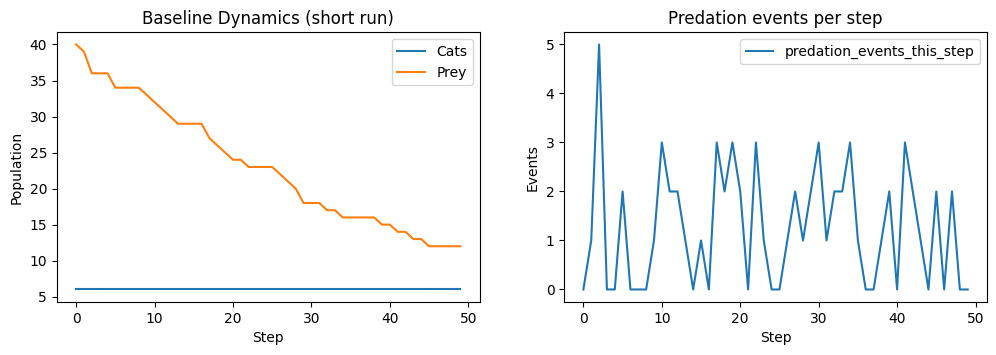

In [18]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,3.5))
ax1.plot(df0["step"], df0["Cats"], label="Cats")
ax1.plot(df0["step"], df0["Prey"], label="Prey")
ax1.set_xlabel("Step"); ax1.set_ylabel("Population"); ax1.set_title("Baseline Dynamics (short run)")
ax1.legend()

ax2.plot(df0["step"], df0["predation_events_this_step"], label="predation_events_this_step")
ax2.set_title("Predation events per step"); ax2.set_xlabel("Step"); ax2.set_ylabel("Events")
ax2.legend()

plt.show()

### 2D Animation
Set `steps` and toggle the **scent** overlay interactively by changing `SCENT[0]`.

In [7]:
# Note: animations can be heavy; keep steps small when previewing.
SCENT = [True]  # toggle in-place inside this list
fig, anim = animate_grid(
    FeralCatModel(
        width=P.width, height=P.height, n_cats=P.n_cats, n_prey=P.n_prey,
        predation_base=P.predation_base, predation_coef=P.predation_coef,
        prey_flee_prob=P.prey_flee_prob, seed=P.seed
    ),
    steps=60, interval_ms=120, figsize=(5,5),
    scent_enabled=lambda: SCENT[0]
)

# To display in Jupyter as JS:
html = anim.to_jshtml()   # generate HTML first
import matplotlib.pyplot as plt
plt.close(fig)            # close the figure to prevent auto-display in Jupyter
from IPython.display import HTML
HTML(html)

## 4. Experiments Plan

We now run experiments to answer questions like:  
- How do **predation intensity** and **prey fleeing** change extinction risk?  
- How does vegetation level mediate outcomes?

We sweep two parameters and replicate each setting across multiple seeds.

In [ ]:
from itertools import product

def experiment_grid(P: Params, predation_coefs=(0.2,0.3,0.4), flee_probs=(0.1,0.2,0.3), runs=5, max_steps=300):
    records = []
    for pc, fp in product(predation_coefs, flee_probs):
        for r in range(runs):
            P2 = Params(**{**P.__dict__, "predation_coef": pc, "prey_flee_prob": fp})
            df, _ = run_once(P2, max_steps=max_steps, seed_offset=r)
            # summarise outcomes
            extinct_step = int(df.loc[df["Prey"]<=0, "step"].min()) if (df["Prey"]<=0).any() else None
            records.append({
                "predation_coef": pc,
                "prey_flee_prob": fp,
                "run": r,
                "extinct": extinct_step is not None,
                "extinct_step": extinct_step if extinct_step is not None else max_steps,
                "final_cats": int(df["Cats"].iloc[-1]),
                "final_prey": int(df["Prey"].iloc[-1]),
                "steps": int(df["total_steps"].iloc[-1])
            })
    return pd.DataFrame.from_records(records)

grid_df = experiment_grid(P, runs=4, max_steps=250)
grid_df.head()

### Extinction Probability by Parameter Setting

In [ ]:
# Aggregate extinction rate
agg = (grid_df
       .groupby(["predation_coef","prey_flee_prob"], as_index=False)
       .agg(extinct_rate=("extinct","mean"), avg_extinct_step=("extinct_step","mean"))
      )

# Pivot for heatmap-like table
pivot = agg.pivot(index="predation_coef", columns="prey_flee_prob", values="extinct_rate")
pivot

In [ ]:
# Simple image-like heatmap without seaborn
fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(pivot.values, aspect="auto", origin="lower")
ax.set_xticks(range(len(pivot.columns))); ax.set_xticklabels(pivot.columns)
ax.set_yticks(range(len(pivot.index)));  ax.set_yticklabels(pivot.index)
ax.set_xlabel("prey_flee_prob"); ax.set_ylabel("predation_coef")
ax.set_title("Extinction Rate (0..1)")
for i in range(pivot.shape[0]):
    for j in range(pivot.shape[1]):
        ax.text(j, i, f"{pivot.values[i,j]:.2f}", ha="center", va="center")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.show()

### Time to Extinction

Lower is Faster

In [ ]:
pivot_tte = agg.pivot(index="predation_coef", columns="prey_flee_prob", values="avg_extinct_step")
fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(pivot_tte.values, aspect="auto", origin="lower")
ax.set_xticks(range(len(pivot_tte.columns))); ax.set_xticklabels(pivot_tte.columns)
ax.set_yticks(range(len(pivot_tte.index)));  ax.set_yticklabels(pivot_tte.index)
ax.set_xlabel("prey_flee_prob"); ax.set_ylabel("predation_coef")
ax.set_title("Avg. Extinction Step")
for i in range(pivot_tte.shape[0]):
    for j in range(pivot_tte.shape[1]):
        ax.text(j, i, f"{pivot_tte.values[i,j]:.0f}", ha="center", va="center")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.show()

## 5. Results & Interpretation (Fill with Your Findings)

- **Overall trends:** (e.g., higher `predation_coef` increases extinction probability; higher `prey_flee_prob` mitigates risk up to a point.)  
- **Thresholds:** Look for parameter combinations where behaviour shifts (e.g., extinction becomes common).  
- **Dynamics:** Reference time-series plots and animation observations.

## 6. Sensitivity & Robustness

Replicate the best/worst settings with more seeds; report mean and variability (e.g., extinction rate, final counts). Provide rationale for chosen ranges.

In [ ]:
# Example: re-run two chosen settings with more seeds
best = dict(predation_coef=0.2, prey_flee_prob=0.3)
worst= dict(predation_coef=0.4, prey_flee_prob=0.1)

def batch_eval(P, setting, runs=10, max_steps=300):
    recs = []
    for r in range(runs):
        P2 = Params(**{**P.__dict__, **setting})
        df,_ = run_once(P2, max_steps=max_steps, seed_offset=r+100)
        extinct = (df["Prey"]<=0).any()
        tte = int(df.loc[df["Prey"]<=0, "step"].min()) if extinct else max_steps
        recs.append({"run":r, "extinct":extinct, "tte":tte,
                     "final_cats": int(df["Cats"].iloc[-1]), "final_prey": int(df["Prey"].iloc[-1])})
    return pd.DataFrame(recs)

df_best  = batch_eval(P, best,  runs=12, max_steps=300)
df_worst = batch_eval(P, worst, runs=12, max_steps=300)

summary = pd.DataFrame({
    "setting": ["best","worst"],
    "extinction_rate": [df_best["extinct"].mean(), df_worst["extinct"].mean()],
    "avg_tte": [df_best["tte"].mean(), df_worst["tte"].mean()],
    "final_prey_mean": [df_best["final_prey"].mean(), df_worst["final_prey"].mean()],
    "final_cats_mean": [df_best["final_cats"].mean(), df_worst["final_cats"].mean()],
})
summary

## 7. Limitations
- Abstracted environment and behaviour rules; real ecosystems are more complex.  
- Parameter calibration is illustrative.  
- No explicit carrying capacity beyond vegetation and predation coupling.

## 8. Conclusion
- Briefly restate what we learned from experiments regarding predation and fleeing behaviours, and emergent dynamics.

## Appendix — How to Run
1. Activate your environment and install dependencies: `pip install -r requirements.txt`.  
2. Open this notebook and run cells top-to-bottom.  
3. To export figures/CSVs, adapt the experiment functions to save under `images/` and `data/`.